In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

from wandb import Api
import pandas as pd
from task import MetaLearningTask
import seaborn as sns
import torch

# Prequential stuff

In [ ]:
runs = Api().runs(
    path="leogagnon/latent_control", filters={"config.sweep_id": "prequential"}
)
runs = [run.id for run in runs]

df = pd.DataFrame(
    columns=[
        "method",
        "seed",
        "seen_tokens",
        "seq_id",
        "n_samples",
        "f_kl",
        "b_kl",
        "nll",
    ]
)

N_RUNS = 25
C_LEN = 250
N_STEPS = 8

# Hardcoded this part cuz made an error in checkpointing
preq_steps = torch.linspace(500, 19000, N_STEPS, dtype=torch.int)
reg_steps = torch.linspace(250, 10000, N_STEPS, dtype=torch.int)
n_tokens = reg_steps * 100000

for id in runs:
    task = MetaLearningTask.from_wandb_id(id).cuda()
    for step_id in range(N_STEPS):
        if task.cfg.data.context_length == [10, 200]:
            method = "preq"
            task.set_to_checkpoint(step=preq_steps[step_id].item())
        else:
            method = "regular"
            task.set_to_checkpoint(step=reg_steps[step_id].item())

        f, b, nll = task.evaluate_pp(N_RUNS, C_LEN + 1, 4)

        for i in range(N_RUNS):
            for j in range(C_LEN):
                df.loc[len(df)] = {
                    "method": method,
                    "seed": task.cfg.data.seed,
                    "seen_tokens": n_tokens[step_id].item(),
                    "seq_id": i,
                    "n_samples": j,
                    "f_kl": f[i, j].item(),
                    "b_kl": b[i, j].item(),
                    "nll": nll[i, j].item(),
                }

df.to_csv('prequential.csv')

In [2]:
df = pd.read_csv('prequential_long.csv')
df['seen_tokens'].unique()

<Axes: xlabel='n_samples', ylabel='b_kl'>

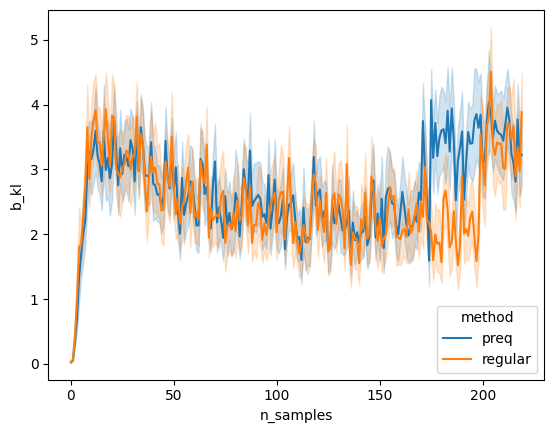

In [27]:
sns.lineplot(df.loc[(df['seen_tokens'] == 220000000) & (df['seed'] == 1)], x='n_samples', y='b_kl', hue='method')
#sns.lineplot(df.loc[(df['seen_tokens'] == 350000000)], x='n_samples', y='b_kl', hue='method')